In [3]:
import os,re,sys
import pandas as pd
import numpy as np
import seaborn as sns # visualisation
import matplotlib.pyplot as plt # visualisation
np.random.seed(2019)
import xgboost as xgb
import lightgbm as lgb
#import catboost as ctb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
os.chdir("D:\\Imarticus\\ML-Repeat\\ml_08November")
%matplotlib inline


In [4]:
os.listdir()

['attrition.csv',
 'HackersEarth_airline.ipynb',
 'test_airline.csv',
 'train_airline.csv']

In [5]:
trainF=pd.read_csv("train_airline.csv")

In [6]:
testF=pd.read_csv("test_airline.csv")

In [7]:
trainF.shape,testF.shape

((10000, 12), (2500, 11))

In [8]:
trainF.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [9]:
testF.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


In [10]:
trainF['Severity'].value_counts()/len(trainF)

Highly_Fatal_And_Damaging                  0.3049
Significant_Damage_And_Serious_Injuries    0.2729
Minor_Damage_And_Injuries                  0.2527
Significant_Damage_And_Fatalities          0.1695
Name: Severity, dtype: float64

In [11]:
trainF.isnull().sum()

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [12]:
### Encoding Prediction Class
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#trainF['Severity_label'], _ = pd.factorize(trainF['Severity'])

trainF['Severity_Label']=le.fit_transform(trainF['Severity'].values)


In [13]:
trainF.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity_Label
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570,1
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128,1
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181,2
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946,3
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054,2


In [14]:
trainF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int64
Total_Safety_Complaints    10000 non-null int64
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int64
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int64
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int64
Severity_Label             10000 non-null int32
dtypes: float64(6), int32(1), int64(5), object(1)
memory usage: 976.6+ KB


C:\Users\Adhvaidh\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


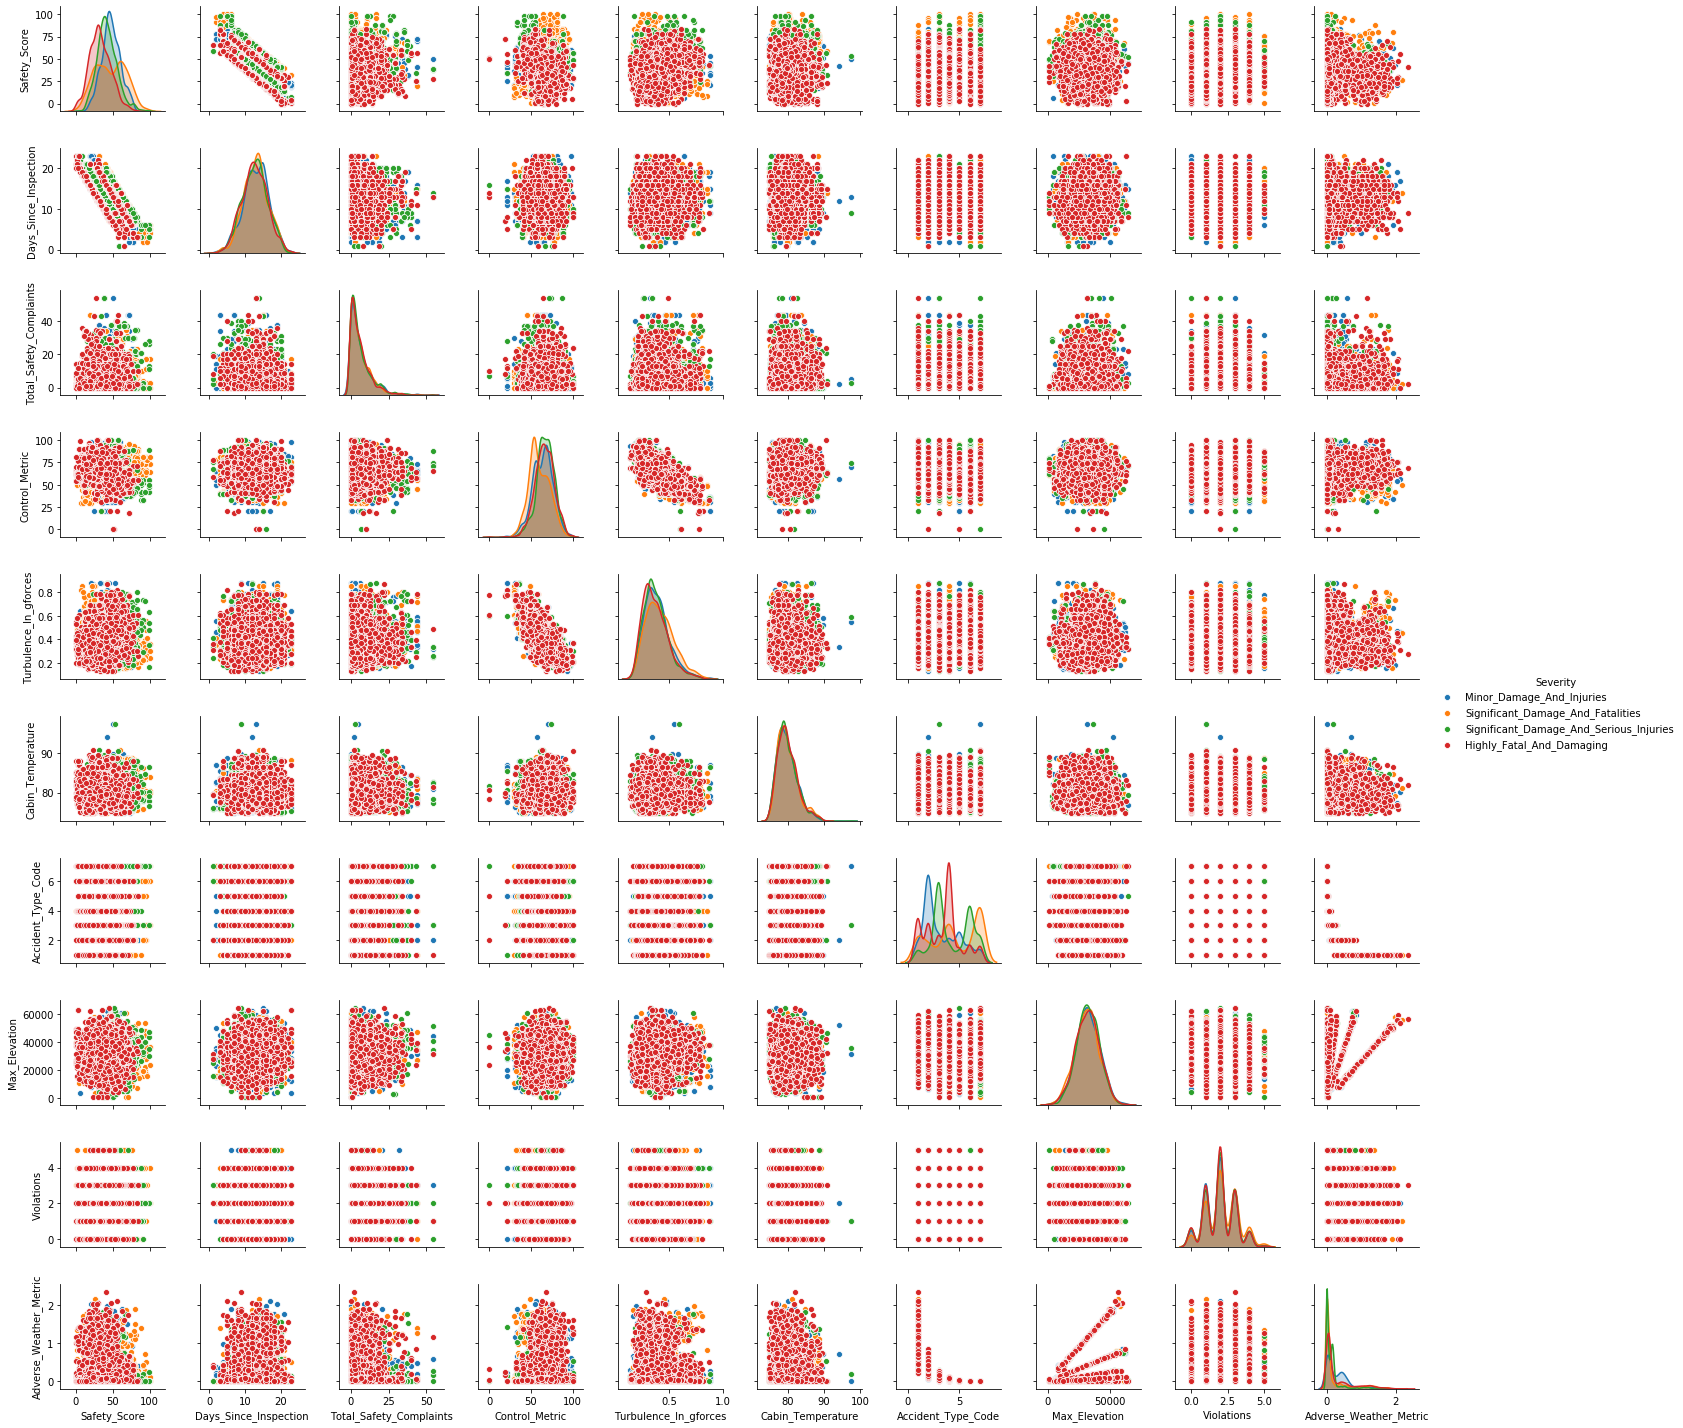

In [15]:
neededcols=list(trainF.select_dtypes(include=['float64','int64','int32']).columns) + ['Severity']
neededcols = [ c for c in neededcols if c not in ['Accident_ID','Severity_Label']]
sns.pairplot(trainF[neededcols],hue='Severity',size=2)

In [16]:
trainF[['Accident_Type_Code','Severity']].head()

,Accident_Type_Code,Severity
0,2,Minor_Damage_And_Injuries
1,2,Minor_Damage_And_Injuries
2,7,Significant_Damage_And_Fatalities
3,3,Significant_Damage_And_Serious_Injuries
4,3,Significant_Damage_And_Fatalities


In [17]:
trainF['Severity'].unique()

array(['Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

In [18]:
for c in ['Accident_Type_Code']:
    Minor_Damage_And_Injuries=trainF[trainF['Severity'] == 'Minor_Damage_And_Injuries'][c].value_counts()
    Significant_Damage_And_Fatalities=trainF[trainF['Severity'] == 'Significant_Damage_And_Fatalities'][c].value_counts()
    Significant_Damage_And_Serious_Injuries=trainF[trainF['Severity'] == 'Significant_Damage_And_Serious_Injuries'][c].value_counts()
    Highly_Fatal_And_Damaging=trainF[trainF['Severity'] == 'Highly_Fatal_And_Damaging'][c].value_counts()

    total=trainF[c].value_counts()

    


In [20]:
print('Minor_Damage_And_Injuries')
Minor_Damage_And_Injuries/len(trainF[trainF['Severity'] == 'Minor_Damage_And_Injuries'])

Minor_Damage_And_Injuries


2    0.404036
5    0.138504
3    0.122279
4    0.106450
1    0.091413
6    0.076375
7    0.060942
Name: Accident_Type_Code, dtype: float64

In [21]:
Significant_Damage_And_Fatalities/len(trainF[trainF['Severity'] == 'Significant_Damage_And_Fatalities'])

7    0.353392
4    0.235398
1    0.153982
2    0.099115
3    0.056047
6    0.054867
5    0.047198
Name: Accident_Type_Code, dtype: float64

In [22]:
Significant_Damage_And_Serious_Injuries/len(trainF[trainF['Severity'] == 'Significant_Damage_And_Serious_Injuries'])

3    0.378527
6    0.263466
7    0.119824
4    0.077318
1    0.057897
2    0.051667
5    0.051301
Name: Accident_Type_Code, dtype: float64

In [23]:
Highly_Fatal_And_Damaging/len(trainF[trainF['Severity'] == 'Highly_Fatal_And_Damaging'])

4    0.386356
1    0.170876
2    0.151197
3    0.103313
6    0.068875
7    0.064283
5    0.055100
Name: Accident_Type_Code, dtype: float64

In [24]:
from sklearn.metrics import log_loss

def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None,label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi,model = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        #if eval_fn is not None:
            #cv_score = eval_fn(val_y, pred_val_y)
        try:
            print(val_y.shape)
            print(pred_val_y.shape)
            print('f1 score is {}'.format(f1_score(val_y, pred_val_y, average='micro') ))
            cv_score=f1_score(val_y, pred_val_y, average='micro')
            print('cvscore is {}'.format(cv_score))
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        except:
            print('in loop number {}'.format(i))
            
            break
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results,model

parameters = {
    #'application': 'binary',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_class':4,
    'num_leaves': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 10,
    'learning_rate': 0.03,
    'verbose': 1 }




def lgbmodel(dev_X, dev_y, val_X, val_y, test, params2):
    
    train_data = lgb.Dataset(dev_X, label=dev_y)
    test_data = lgb.Dataset(val_X, label=val_y)

   
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=200,
                           early_stopping_rounds=40)
    feature_im = model.feature_importance()
    
    print('Predict 1/2')
    pred_test_y = model.predict(val_X).argmax(axis=1)
    print('len of pred_test_y is {}'.format(pred_test_y.shape))
    print('Predict 2/2')
    pred_test_y2 = model.predict(test).argmax(axis=1)
    print('len of pred_test_y2 is {}'.format(pred_test_y2.shape))
    return pred_test_y, pred_test_y2, feature_im,model


    


In [25]:
trainF.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID,Severity_Label
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570,1
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128,1
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181,2
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946,3
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054,2


In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(trainF.iloc[:,1:], trainF['Severity_Label'],
                                         test_size=0.1, random_state=42, stratify=trainF['Severity_Label'],shuffle=True)


In [27]:
colneeded=[f for f in x_train.columns if f not in ['Severity_Label','Severity','Accident_ID']]

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [29]:
n_folds = 10
results,model = run_cv_model(x_train[colneeded], x_valid[colneeded], x_train['Severity_Label'], lgbmodel, parameters,f1_score, 'f1', n_folds=n_folds)


-------------------------------------------
Started f1 fold 1/10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 8098, number of used features: 10
[LightGBM] [Info] Start training from score -1.187804
[LightGBM] [Info] Start training from score -1.375730
[LightGBM] [Info] Start training from score -1.774619
[LightGBM] [Info] Start training from score -1.298625
[1]	valid_0's multi_logloss: 1.32554
Training until validation scores don't improve for 40 rounds
[2]	valid_0's multi_logloss: 1.29401
[3]	valid_0's multi_logloss: 1.25939
[4]	valid_0's multi_logloss: 1.22688
[5]	valid_0's multi_logloss: 1.20224
[6]	valid_0's multi_logloss: 1.17427
[7]	valid_0's multi_logloss: 1.15035
[8]	valid_0's multi_logloss: 1.12551
[9]	val

[6]	valid_0's multi_logloss: 1.16687
[7]	valid_0's multi_logloss: 1.14267
[8]	valid_0's multi_logloss: 1.11761
[9]	valid_0's multi_logloss: 1.10241
[10]	valid_0's multi_logloss: 1.07997
[11]	valid_0's multi_logloss: 1.05865
[12]	valid_0's multi_logloss: 1.04011
[13]	valid_0's multi_logloss: 1.01996
[14]	valid_0's multi_logloss: 1.00032
[15]	valid_0's multi_logloss: 0.981586
[16]	valid_0's multi_logloss: 0.964336
[17]	valid_0's multi_logloss: 0.951572
[18]	valid_0's multi_logloss: 0.93622
[19]	valid_0's multi_logloss: 0.922622
[20]	valid_0's multi_logloss: 0.913757
[21]	valid_0's multi_logloss: 0.90351
[22]	valid_0's multi_logloss: 0.890474
[23]	valid_0's multi_logloss: 0.87593
[24]	valid_0's multi_logloss: 0.862693
[25]	valid_0's multi_logloss: 0.848565
[26]	valid_0's multi_logloss: 0.836954
[27]	valid_0's multi_logloss: 0.823872
[28]	valid_0's multi_logloss: 0.813727
[29]	valid_0's multi_logloss: 0.801988
[30]	valid_0's multi_logloss: 0.789797
[31]	valid_0's multi_logloss: 0.778262
[3

[59]	valid_0's multi_logloss: 0.598803
[60]	valid_0's multi_logloss: 0.593721
[61]	valid_0's multi_logloss: 0.587705
[62]	valid_0's multi_logloss: 0.583577
[63]	valid_0's multi_logloss: 0.579687
[64]	valid_0's multi_logloss: 0.574917
[65]	valid_0's multi_logloss: 0.571513
[66]	valid_0's multi_logloss: 0.566108
[67]	valid_0's multi_logloss: 0.560951
[68]	valid_0's multi_logloss: 0.555547
[69]	valid_0's multi_logloss: 0.550464
[70]	valid_0's multi_logloss: 0.546916
[71]	valid_0's multi_logloss: 0.544465
[72]	valid_0's multi_logloss: 0.5405
[73]	valid_0's multi_logloss: 0.536574
[74]	valid_0's multi_logloss: 0.534048
[75]	valid_0's multi_logloss: 0.52926
[76]	valid_0's multi_logloss: 0.527115
[77]	valid_0's multi_logloss: 0.523778
[78]	valid_0's multi_logloss: 0.521041
[79]	valid_0's multi_logloss: 0.51861
[80]	valid_0's multi_logloss: 0.515667
[81]	valid_0's multi_logloss: 0.512648
[82]	valid_0's multi_logloss: 0.509188
[83]	valid_0's multi_logloss: 0.505478
[84]	valid_0's multi_logloss:

[91]	valid_0's multi_logloss: 0.451851
[92]	valid_0's multi_logloss: 0.450558
[93]	valid_0's multi_logloss: 0.447324
[94]	valid_0's multi_logloss: 0.444559
[95]	valid_0's multi_logloss: 0.442116
[96]	valid_0's multi_logloss: 0.439997
[97]	valid_0's multi_logloss: 0.438614
[98]	valid_0's multi_logloss: 0.437323
[99]	valid_0's multi_logloss: 0.435134
[100]	valid_0's multi_logloss: 0.433334
[101]	valid_0's multi_logloss: 0.432357
[102]	valid_0's multi_logloss: 0.430433
[103]	valid_0's multi_logloss: 0.428011
[104]	valid_0's multi_logloss: 0.42655
[105]	valid_0's multi_logloss: 0.424441
[106]	valid_0's multi_logloss: 0.421488
[107]	valid_0's multi_logloss: 0.418964
[108]	valid_0's multi_logloss: 0.417008
[109]	valid_0's multi_logloss: 0.414197
[110]	valid_0's multi_logloss: 0.412284
[111]	valid_0's multi_logloss: 0.409766
[112]	valid_0's multi_logloss: 0.408242
[113]	valid_0's multi_logloss: 0.406097
[114]	valid_0's multi_logloss: 0.404048
[115]	valid_0's multi_logloss: 0.40275
[116]	valid

[107]	valid_0's multi_logloss: 0.43738
[108]	valid_0's multi_logloss: 0.435181
[109]	valid_0's multi_logloss: 0.433284
[110]	valid_0's multi_logloss: 0.430956
[111]	valid_0's multi_logloss: 0.42808
[112]	valid_0's multi_logloss: 0.425375
[113]	valid_0's multi_logloss: 0.42304
[114]	valid_0's multi_logloss: 0.420559
[115]	valid_0's multi_logloss: 0.419132
[116]	valid_0's multi_logloss: 0.416702
[117]	valid_0's multi_logloss: 0.414038
[118]	valid_0's multi_logloss: 0.411566
[119]	valid_0's multi_logloss: 0.409516
[120]	valid_0's multi_logloss: 0.407549
[121]	valid_0's multi_logloss: 0.406154
[122]	valid_0's multi_logloss: 0.405622
[123]	valid_0's multi_logloss: 0.404529
[124]	valid_0's multi_logloss: 0.403266
[125]	valid_0's multi_logloss: 0.402324
[126]	valid_0's multi_logloss: 0.400557
[127]	valid_0's multi_logloss: 0.399472
[128]	valid_0's multi_logloss: 0.398283
[129]	valid_0's multi_logloss: 0.396644
[130]	valid_0's multi_logloss: 0.395664
[131]	valid_0's multi_logloss: 0.394396
[13

[99]	valid_0's multi_logloss: 0.450058
[100]	valid_0's multi_logloss: 0.448153
[101]	valid_0's multi_logloss: 0.446223
[102]	valid_0's multi_logloss: 0.445035
[103]	valid_0's multi_logloss: 0.44289
[104]	valid_0's multi_logloss: 0.440879
[105]	valid_0's multi_logloss: 0.43928
[106]	valid_0's multi_logloss: 0.437077
[107]	valid_0's multi_logloss: 0.435056
[108]	valid_0's multi_logloss: 0.432674
[109]	valid_0's multi_logloss: 0.431316
[110]	valid_0's multi_logloss: 0.428822
[111]	valid_0's multi_logloss: 0.426291
[112]	valid_0's multi_logloss: 0.424676
[113]	valid_0's multi_logloss: 0.422984
[114]	valid_0's multi_logloss: 0.421011
[115]	valid_0's multi_logloss: 0.419571
[116]	valid_0's multi_logloss: 0.417564
[117]	valid_0's multi_logloss: 0.416514
[118]	valid_0's multi_logloss: 0.415261
[119]	valid_0's multi_logloss: 0.414037
[120]	valid_0's multi_logloss: 0.41262
[121]	valid_0's multi_logloss: 0.411175
[122]	valid_0's multi_logloss: 0.410436
[123]	valid_0's multi_logloss: 0.408156
[124

[95]	valid_0's multi_logloss: 0.481302
[96]	valid_0's multi_logloss: 0.479251
[97]	valid_0's multi_logloss: 0.477247
[98]	valid_0's multi_logloss: 0.475255
[99]	valid_0's multi_logloss: 0.471458
[100]	valid_0's multi_logloss: 0.467587
[101]	valid_0's multi_logloss: 0.465561
[102]	valid_0's multi_logloss: 0.463925
[103]	valid_0's multi_logloss: 0.462202
[104]	valid_0's multi_logloss: 0.459652
[105]	valid_0's multi_logloss: 0.456455
[106]	valid_0's multi_logloss: 0.452638
[107]	valid_0's multi_logloss: 0.450145
[108]	valid_0's multi_logloss: 0.447776
[109]	valid_0's multi_logloss: 0.445215
[110]	valid_0's multi_logloss: 0.443308
[111]	valid_0's multi_logloss: 0.441392
[112]	valid_0's multi_logloss: 0.439488
[113]	valid_0's multi_logloss: 0.438087
[114]	valid_0's multi_logloss: 0.435772
[115]	valid_0's multi_logloss: 0.435006
[116]	valid_0's multi_logloss: 0.433481
[117]	valid_0's multi_logloss: 0.431808
[118]	valid_0's multi_logloss: 0.43013
[119]	valid_0's multi_logloss: 0.428635
[120]	

[85]	valid_0's multi_logloss: 0.479997
[86]	valid_0's multi_logloss: 0.477547
[87]	valid_0's multi_logloss: 0.475069
[88]	valid_0's multi_logloss: 0.472495
[89]	valid_0's multi_logloss: 0.469751
[90]	valid_0's multi_logloss: 0.467005
[91]	valid_0's multi_logloss: 0.464413
[92]	valid_0's multi_logloss: 0.460155
[93]	valid_0's multi_logloss: 0.457742
[94]	valid_0's multi_logloss: 0.45458
[95]	valid_0's multi_logloss: 0.451179
[96]	valid_0's multi_logloss: 0.448976
[97]	valid_0's multi_logloss: 0.447647
[98]	valid_0's multi_logloss: 0.446214
[99]	valid_0's multi_logloss: 0.443756
[100]	valid_0's multi_logloss: 0.440581
[101]	valid_0's multi_logloss: 0.43885
[102]	valid_0's multi_logloss: 0.437397
[103]	valid_0's multi_logloss: 0.435211
[104]	valid_0's multi_logloss: 0.43433
[105]	valid_0's multi_logloss: 0.432153
[106]	valid_0's multi_logloss: 0.429633
[107]	valid_0's multi_logloss: 0.427832
[108]	valid_0's multi_logloss: 0.425634
[109]	valid_0's multi_logloss: 0.424062
[110]	valid_0's mu

[83]	valid_0's multi_logloss: 0.503631
[84]	valid_0's multi_logloss: 0.500564
[85]	valid_0's multi_logloss: 0.498239
[86]	valid_0's multi_logloss: 0.49492
[87]	valid_0's multi_logloss: 0.492356
[88]	valid_0's multi_logloss: 0.489862
[89]	valid_0's multi_logloss: 0.487064
[90]	valid_0's multi_logloss: 0.483309
[91]	valid_0's multi_logloss: 0.478878
[92]	valid_0's multi_logloss: 0.475213
[93]	valid_0's multi_logloss: 0.471171
[94]	valid_0's multi_logloss: 0.467432
[95]	valid_0's multi_logloss: 0.463954
[96]	valid_0's multi_logloss: 0.462438
[97]	valid_0's multi_logloss: 0.461382
[98]	valid_0's multi_logloss: 0.459888
[99]	valid_0's multi_logloss: 0.457637
[100]	valid_0's multi_logloss: 0.455815
[101]	valid_0's multi_logloss: 0.454647
[102]	valid_0's multi_logloss: 0.45255
[103]	valid_0's multi_logloss: 0.449936
[104]	valid_0's multi_logloss: 0.44796
[105]	valid_0's multi_logloss: 0.444885
[106]	valid_0's multi_logloss: 0.441518
[107]	valid_0's multi_logloss: 0.43848
[108]	valid_0's multi

[111]	valid_0's multi_logloss: 0.411221
[112]	valid_0's multi_logloss: 0.409739
[113]	valid_0's multi_logloss: 0.407278
[114]	valid_0's multi_logloss: 0.40546
[115]	valid_0's multi_logloss: 0.404297
[116]	valid_0's multi_logloss: 0.40233
[117]	valid_0's multi_logloss: 0.400779
[118]	valid_0's multi_logloss: 0.399908
[119]	valid_0's multi_logloss: 0.398756
[120]	valid_0's multi_logloss: 0.397187
[121]	valid_0's multi_logloss: 0.395491
[122]	valid_0's multi_logloss: 0.3945
[123]	valid_0's multi_logloss: 0.392575
[124]	valid_0's multi_logloss: 0.39128
[125]	valid_0's multi_logloss: 0.389974
[126]	valid_0's multi_logloss: 0.388382
[127]	valid_0's multi_logloss: 0.386472
[128]	valid_0's multi_logloss: 0.385818
[129]	valid_0's multi_logloss: 0.384849
[130]	valid_0's multi_logloss: 0.383975
[131]	valid_0's multi_logloss: 0.382854
[132]	valid_0's multi_logloss: 0.381518
[133]	valid_0's multi_logloss: 0.380123
[134]	valid_0's multi_logloss: 0.37878
[135]	valid_0's multi_logloss: 0.376237
[136]	

In [30]:
## final model

train_data = lgb.Dataset(x_train[colneeded], label=y_train)
test_data = lgb.Dataset(x_valid[colneeded], label=y_valid)
model = lgb.train(parameters,train_data,valid_sets=test_data,num_boost_round=500,early_stopping_rounds=40)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 10
[LightGBM] [Info] Start training from score -1.187808
[LightGBM] [Info] Start training from score -1.375684
[LightGBM] [Info] Start training from score -1.774575
[LightGBM] [Info] Start training from score -1.298691
[1]	valid_0's multi_logloss: 1.32445
Training until validation scores don't improve for 40 rounds
[2]	valid_0's multi_logloss: 1.29158
[3]	valid_0's multi_logloss: 1.25561
[4]	valid_0's multi_logloss: 1.22236
[5]	valid_0's multi_logloss: 1.19708
[6]	valid_0's multi_logloss: 1.16714
[7]	valid_0's multi_logloss: 1.1425
[8]	valid_0's multi_logloss: 1.117
[9]	valid_0's multi_logloss: 1.10242
[10]	valid_0's multi_logloss: 1.07983
[11]	valid_0's multi_logloss: 1.05842
[12]	valid_0's multi_loglo

[209]	valid_0's multi_logloss: 0.313156
[210]	valid_0's multi_logloss: 0.312854
[211]	valid_0's multi_logloss: 0.312421
[212]	valid_0's multi_logloss: 0.312009
[213]	valid_0's multi_logloss: 0.311427
[214]	valid_0's multi_logloss: 0.311248
[215]	valid_0's multi_logloss: 0.310118
[216]	valid_0's multi_logloss: 0.309563
[217]	valid_0's multi_logloss: 0.309356
[218]	valid_0's multi_logloss: 0.309294
[219]	valid_0's multi_logloss: 0.308444
[220]	valid_0's multi_logloss: 0.307846
[221]	valid_0's multi_logloss: 0.307024
[222]	valid_0's multi_logloss: 0.306263
[223]	valid_0's multi_logloss: 0.305461
[224]	valid_0's multi_logloss: 0.304783
[225]	valid_0's multi_logloss: 0.303908
[226]	valid_0's multi_logloss: 0.303308
[227]	valid_0's multi_logloss: 0.302367
[228]	valid_0's multi_logloss: 0.301995
[229]	valid_0's multi_logloss: 0.301475
[230]	valid_0's multi_logloss: 0.300803
[231]	valid_0's multi_logloss: 0.299305
[232]	valid_0's multi_logloss: 0.298937
[233]	valid_0's multi_logloss: 0.297231


[438]	valid_0's multi_logloss: 0.22498
[439]	valid_0's multi_logloss: 0.224783
[440]	valid_0's multi_logloss: 0.224516
[441]	valid_0's multi_logloss: 0.224031
[442]	valid_0's multi_logloss: 0.223802
[443]	valid_0's multi_logloss: 0.223227
[444]	valid_0's multi_logloss: 0.22264
[445]	valid_0's multi_logloss: 0.222209
[446]	valid_0's multi_logloss: 0.221676
[447]	valid_0's multi_logloss: 0.221233
[448]	valid_0's multi_logloss: 0.220758
[449]	valid_0's multi_logloss: 0.220459
[450]	valid_0's multi_logloss: 0.219771
[451]	valid_0's multi_logloss: 0.219485
[452]	valid_0's multi_logloss: 0.219227
[453]	valid_0's multi_logloss: 0.219009
[454]	valid_0's multi_logloss: 0.21893
[455]	valid_0's multi_logloss: 0.218592
[456]	valid_0's multi_logloss: 0.218373
[457]	valid_0's multi_logloss: 0.218095
[458]	valid_0's multi_logloss: 0.217823
[459]	valid_0's multi_logloss: 0.217511
[460]	valid_0's multi_logloss: 0.217335
[461]	valid_0's multi_logloss: 0.217161
[462]	valid_0's multi_logloss: 0.217118
[46

In [31]:
### Predicting on Test data and inversing the label encoding
predTest=le.inverse_transform(model.predict(testF[colneeded]).argmax(axis=1))

In [231]:
#del testF['Severity']

In [32]:
testF['Severity']=predTest
## Creating the submission file
subF=testF[['Accident_ID','Severity']]

In [33]:
subF.to_csv("sub2lgb.csv",index=None) ## writing the file

In [34]:
xgb2 = xgb.XGBClassifier(max_depth=7, n_estimators=1200, learning_rate=0.04,objective="multi:softmax",
                         tree_method='auto',random_state=42,colsample_bytree=0.8,subsample=0.85,
                        eval_metric ="mlogloss",
                        gamma=0.2,reg_alpha=0.4,min_child_weight = 3)

In [35]:
## xgboost



eval_set = [(x_train[colneeded], x_train['Severity_Label']), (x_valid[colneeded], x_valid['Severity_Label'])]

kfold = StratifiedKFold(n_splits=10, random_state=7)

results = cross_val_score(xgb2, x_train[colneeded], x_train['Severity_Label'], cv=kfold)

#xgb2.fit(x_train[colneeded], x_train['damage_grade'],early_stopping_rounds=120, eval_metric=["mlogloss"],eval_set=eval_set)



In [243]:
results

array([0.9578714 , 0.96008869, 0.9556541 , 0.96230599, 0.96111111,
       0.95777778, 0.95991091, 0.96547884, 0.95434298, 0.96659243])

In [155]:
#results ## original

array([0.95898004, 0.95898004, 0.94678492, 0.96119734, 0.95555556,
       0.95555556, 0.95879733, 0.96659243, 0.95434298, 0.96547884])

In [211]:
xgb2.fit(x_train[colneeded], x_train['Severity_Label'],early_stopping_rounds=30, eval_metric=["mlogloss"],eval_set=eval_set)


[0]	validation_0-mlogloss:1.36568	validation_1-mlogloss:1.36658
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.34833	validation_1-mlogloss:1.35081
[2]	validation_0-mlogloss:1.32667	validation_1-mlogloss:1.3303
[3]	validation_0-mlogloss:1.30376	validation_1-mlogloss:1.30825
[4]	validation_0-mlogloss:1.28402	validation_1-mlogloss:1.28926
[5]	validation_0-mlogloss:1.26137	validation_1-mlogloss:1.26758
[6]	validation_0-mlogloss:1.23972	validation_1-mlogloss:1.24649
[7]	validation_0-mlogloss:1.2173	validation_1-mlogloss:1.22486
[8]	validation_0-mlogloss:1.19849	validation_1-mlogloss:1.20716
[9]	validation_0-mlogloss:1.18219	validation_1-mlogloss:1.1918
[10]	validation_0-mlogloss:1.16677	validation_1-mlogloss:1.1771
[11]	validation_0-mlogloss:1.14952	validation_1-mlogloss:1.16074
[12]	validation_0-mlogloss:1.1384	validation_1-mlogloss:1.15084
[13

[121]	validation_0-mlogloss:0.368748	validation_1-mlogloss:0.430679
[122]	validation_0-mlogloss:0.365489	validation_1-mlogloss:0.427696
[123]	validation_0-mlogloss:0.363125	validation_1-mlogloss:0.42556
[124]	validation_0-mlogloss:0.360069	validation_1-mlogloss:0.422714
[125]	validation_0-mlogloss:0.356955	validation_1-mlogloss:0.419822
[126]	validation_0-mlogloss:0.352121	validation_1-mlogloss:0.414991
[127]	validation_0-mlogloss:0.348586	validation_1-mlogloss:0.411654
[128]	validation_0-mlogloss:0.3453	validation_1-mlogloss:0.408636
[129]	validation_0-mlogloss:0.341921	validation_1-mlogloss:0.40526
[130]	validation_0-mlogloss:0.33768	validation_1-mlogloss:0.401127
[131]	validation_0-mlogloss:0.335386	validation_1-mlogloss:0.399272
[132]	validation_0-mlogloss:0.331872	validation_1-mlogloss:0.396006
[133]	validation_0-mlogloss:0.328188	validation_1-mlogloss:0.392475
[134]	validation_0-mlogloss:0.325733	validation_1-mlogloss:0.39018
[135]	validation_0-mlogloss:0.324227	validation_1-mlog

[242]	validation_0-mlogloss:0.156164	validation_1-mlogloss:0.233455
[243]	validation_0-mlogloss:0.155451	validation_1-mlogloss:0.232828
[244]	validation_0-mlogloss:0.154785	validation_1-mlogloss:0.232207
[245]	validation_0-mlogloss:0.153704	validation_1-mlogloss:0.231205
[246]	validation_0-mlogloss:0.153268	validation_1-mlogloss:0.230925
[247]	validation_0-mlogloss:0.152118	validation_1-mlogloss:0.229887
[248]	validation_0-mlogloss:0.151573	validation_1-mlogloss:0.229408
[249]	validation_0-mlogloss:0.150747	validation_1-mlogloss:0.228643
[250]	validation_0-mlogloss:0.15021	validation_1-mlogloss:0.228135
[251]	validation_0-mlogloss:0.149467	validation_1-mlogloss:0.227412
[252]	validation_0-mlogloss:0.14865	validation_1-mlogloss:0.226699
[253]	validation_0-mlogloss:0.147309	validation_1-mlogloss:0.225321
[254]	validation_0-mlogloss:0.14679	validation_1-mlogloss:0.224992
[255]	validation_0-mlogloss:0.146203	validation_1-mlogloss:0.224459
[256]	validation_0-mlogloss:0.145655	validation_1-m

[363]	validation_0-mlogloss:0.092096	validation_1-mlogloss:0.1777
[364]	validation_0-mlogloss:0.091918	validation_1-mlogloss:0.177539
[365]	validation_0-mlogloss:0.091711	validation_1-mlogloss:0.177439
[366]	validation_0-mlogloss:0.091458	validation_1-mlogloss:0.177314
[367]	validation_0-mlogloss:0.091311	validation_1-mlogloss:0.177245
[368]	validation_0-mlogloss:0.091017	validation_1-mlogloss:0.176961
[369]	validation_0-mlogloss:0.090886	validation_1-mlogloss:0.176915
[370]	validation_0-mlogloss:0.09053	validation_1-mlogloss:0.176637
[371]	validation_0-mlogloss:0.090218	validation_1-mlogloss:0.176396
[372]	validation_0-mlogloss:0.089913	validation_1-mlogloss:0.176206
[373]	validation_0-mlogloss:0.089556	validation_1-mlogloss:0.175862
[374]	validation_0-mlogloss:0.089421	validation_1-mlogloss:0.175775
[375]	validation_0-mlogloss:0.089212	validation_1-mlogloss:0.175651
[376]	validation_0-mlogloss:0.088761	validation_1-mlogloss:0.175185
[377]	validation_0-mlogloss:0.088492	validation_1-m

[484]	validation_0-mlogloss:0.068709	validation_1-mlogloss:0.16095
[485]	validation_0-mlogloss:0.068471	validation_1-mlogloss:0.160751
[486]	validation_0-mlogloss:0.068347	validation_1-mlogloss:0.160687
[487]	validation_0-mlogloss:0.068217	validation_1-mlogloss:0.160609
[488]	validation_0-mlogloss:0.068087	validation_1-mlogloss:0.160513
[489]	validation_0-mlogloss:0.06795	validation_1-mlogloss:0.160423
[490]	validation_0-mlogloss:0.067833	validation_1-mlogloss:0.160387
[491]	validation_0-mlogloss:0.06768	validation_1-mlogloss:0.160272
[492]	validation_0-mlogloss:0.06755	validation_1-mlogloss:0.160202
[493]	validation_0-mlogloss:0.067373	validation_1-mlogloss:0.160089
[494]	validation_0-mlogloss:0.067227	validation_1-mlogloss:0.159968
[495]	validation_0-mlogloss:0.067087	validation_1-mlogloss:0.159872
[496]	validation_0-mlogloss:0.066912	validation_1-mlogloss:0.159692
[497]	validation_0-mlogloss:0.066793	validation_1-mlogloss:0.159598
[498]	validation_0-mlogloss:0.06669	validation_1-mlo

[605]	validation_0-mlogloss:0.054911	validation_1-mlogloss:0.152099
[606]	validation_0-mlogloss:0.054832	validation_1-mlogloss:0.152064
[607]	validation_0-mlogloss:0.054748	validation_1-mlogloss:0.151997
[608]	validation_0-mlogloss:0.054657	validation_1-mlogloss:0.151909
[609]	validation_0-mlogloss:0.054544	validation_1-mlogloss:0.151857
[610]	validation_0-mlogloss:0.054464	validation_1-mlogloss:0.151743
[611]	validation_0-mlogloss:0.054402	validation_1-mlogloss:0.151729
[612]	validation_0-mlogloss:0.054349	validation_1-mlogloss:0.151723
[613]	validation_0-mlogloss:0.054302	validation_1-mlogloss:0.151729
[614]	validation_0-mlogloss:0.05417	validation_1-mlogloss:0.151638
[615]	validation_0-mlogloss:0.054072	validation_1-mlogloss:0.151581
[616]	validation_0-mlogloss:0.05398	validation_1-mlogloss:0.151518
[617]	validation_0-mlogloss:0.053905	validation_1-mlogloss:0.151496
[618]	validation_0-mlogloss:0.053862	validation_1-mlogloss:0.151471
[619]	validation_0-mlogloss:0.053783	validation_1-

[726]	validation_0-mlogloss:0.045966	validation_1-mlogloss:0.146572
[727]	validation_0-mlogloss:0.045921	validation_1-mlogloss:0.14655
[728]	validation_0-mlogloss:0.045867	validation_1-mlogloss:0.146548
[729]	validation_0-mlogloss:0.045778	validation_1-mlogloss:0.146484
[730]	validation_0-mlogloss:0.045729	validation_1-mlogloss:0.146441
[731]	validation_0-mlogloss:0.045695	validation_1-mlogloss:0.146391
[732]	validation_0-mlogloss:0.045664	validation_1-mlogloss:0.146397
[733]	validation_0-mlogloss:0.045628	validation_1-mlogloss:0.146381
[734]	validation_0-mlogloss:0.045575	validation_1-mlogloss:0.146334
[735]	validation_0-mlogloss:0.045529	validation_1-mlogloss:0.146326
[736]	validation_0-mlogloss:0.04547	validation_1-mlogloss:0.146341
[737]	validation_0-mlogloss:0.045419	validation_1-mlogloss:0.146352
[738]	validation_0-mlogloss:0.045313	validation_1-mlogloss:0.146272
[739]	validation_0-mlogloss:0.045262	validation_1-mlogloss:0.146272
[740]	validation_0-mlogloss:0.045186	validation_1-

[847]	validation_0-mlogloss:0.039851	validation_1-mlogloss:0.142611
[848]	validation_0-mlogloss:0.039818	validation_1-mlogloss:0.142606
[849]	validation_0-mlogloss:0.03979	validation_1-mlogloss:0.142604
[850]	validation_0-mlogloss:0.039729	validation_1-mlogloss:0.142547
[851]	validation_0-mlogloss:0.039693	validation_1-mlogloss:0.142522
[852]	validation_0-mlogloss:0.039653	validation_1-mlogloss:0.142512
[853]	validation_0-mlogloss:0.039623	validation_1-mlogloss:0.142501
[854]	validation_0-mlogloss:0.039574	validation_1-mlogloss:0.142477
[855]	validation_0-mlogloss:0.039492	validation_1-mlogloss:0.1424
[856]	validation_0-mlogloss:0.039461	validation_1-mlogloss:0.142387
[857]	validation_0-mlogloss:0.039419	validation_1-mlogloss:0.142364
[858]	validation_0-mlogloss:0.039381	validation_1-mlogloss:0.142357
[859]	validation_0-mlogloss:0.039325	validation_1-mlogloss:0.142374
[860]	validation_0-mlogloss:0.039298	validation_1-mlogloss:0.142373
[861]	validation_0-mlogloss:0.039256	validation_1-m

[968]	validation_0-mlogloss:0.035473	validation_1-mlogloss:0.139915
[969]	validation_0-mlogloss:0.03544	validation_1-mlogloss:0.139848
[970]	validation_0-mlogloss:0.035407	validation_1-mlogloss:0.139835
[971]	validation_0-mlogloss:0.035355	validation_1-mlogloss:0.139752
[972]	validation_0-mlogloss:0.035332	validation_1-mlogloss:0.139751
[973]	validation_0-mlogloss:0.035305	validation_1-mlogloss:0.139711
[974]	validation_0-mlogloss:0.035287	validation_1-mlogloss:0.139724
[975]	validation_0-mlogloss:0.035263	validation_1-mlogloss:0.139678
[976]	validation_0-mlogloss:0.035221	validation_1-mlogloss:0.1396
[977]	validation_0-mlogloss:0.035199	validation_1-mlogloss:0.139609
[978]	validation_0-mlogloss:0.035173	validation_1-mlogloss:0.139627
[979]	validation_0-mlogloss:0.035154	validation_1-mlogloss:0.139605
[980]	validation_0-mlogloss:0.035122	validation_1-mlogloss:0.139545
[981]	validation_0-mlogloss:0.035078	validation_1-mlogloss:0.139497
[982]	validation_0-mlogloss:0.035035	validation_1-m

[1088]	validation_0-mlogloss:0.032463	validation_1-mlogloss:0.137931
[1089]	validation_0-mlogloss:0.032446	validation_1-mlogloss:0.137916
[1090]	validation_0-mlogloss:0.032423	validation_1-mlogloss:0.137909
[1091]	validation_0-mlogloss:0.032409	validation_1-mlogloss:0.137898
[1092]	validation_0-mlogloss:0.032386	validation_1-mlogloss:0.137883
[1093]	validation_0-mlogloss:0.032351	validation_1-mlogloss:0.137878
[1094]	validation_0-mlogloss:0.032339	validation_1-mlogloss:0.137873
[1095]	validation_0-mlogloss:0.032314	validation_1-mlogloss:0.137863
[1096]	validation_0-mlogloss:0.032289	validation_1-mlogloss:0.137857
[1097]	validation_0-mlogloss:0.03227	validation_1-mlogloss:0.137849
[1098]	validation_0-mlogloss:0.032243	validation_1-mlogloss:0.137829
[1099]	validation_0-mlogloss:0.032227	validation_1-mlogloss:0.137845
[1100]	validation_0-mlogloss:0.032205	validation_1-mlogloss:0.137841
[1101]	validation_0-mlogloss:0.03217	validation_1-mlogloss:0.137777
[1102]	validation_0-mlogloss:0.03212

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
       gamma=0.2, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.85, tree_method='auto', verbosity=1)

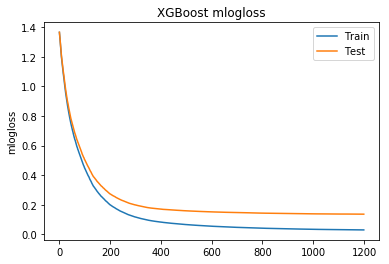

In [212]:
results2 = xgb2.evals_result()
epochs = len(results2['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results2['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results2['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

In [213]:
pred_xgb=le.inverse_transform(xgb2.predict(testF[colneeded]))

In [214]:
del testF['Severity']

In [215]:
testF['Severity']=pred_xgb
## Creating the submission file
subF=testF[['Accident_ID','Severity']]

In [216]:
subF.to_csv("predxgb_sub5.csv",index=None)

In [234]:
## checking Hard voting of three predictions 
os.listdir()

['predxgb_sub1.csv',
 'predxgb_sub2.csv',
 'predxgb_sub3.csv',
 'predxgb_sub4.csv',
 'predxgb_sub5.csv',
 'sample_submission.csv',
 'sub1.csv',
 'sub2lgb.csv',
 'test.csv',
 'train.csv',
 'votingensemble.csv']

In [235]:
sub1=pd.read_csv('sub1.csv')
predxgb_sub1=pd.read_csv('predxgb_sub1.csv')
predxgb_sub2=pd.read_csv('predxgb_sub2.csv')
predxgb_sub3=pd.read_csv('predxgb_sub3.csv')
predxgb_sub4=pd.read_csv('predxgb_sub4.csv')
predxgb_sub5=pd.read_csv('predxgb_sub5.csv')
sub2lgb=pd.read_csv('sub2lgb.csv')


In [236]:
predxgb_sub2.head()

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities


In [220]:
from statistics import mode

In [239]:
final_pred = np.array([])
for i in range(0,len(testF)):
    final_pred = np.append(final_pred, mode([predxgb_sub1['Severity'][i], predxgb_sub2['Severity'][i],
                                            predxgb_sub5['Severity'][i],predxgb_sub3['Severity'][i],
                                             predxgb_sub4['Severity'][i]]))

In [223]:
del testF['Severity']
testF['Severity']=final_pred
## Creating the submission file
subF=testF[['Accident_ID','Severity']]
subF.to_csv("votingensemble.csv",index=None)